In [109]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange


In [110]:
DATA_DIR = os.path.join(os.getcwd(), "data")
FACTORS = [
    "valuation",
    "profitability",
    "growth",
    "quality",
    "liquidity",
    "momentum_and_reversal",
]
TRAIN_PERIOD = pd.date_range("2011-01-05", "2011-12-31", freq="7D")
TEST_PERIOD = pd.date_range("2016-01-05", "2016-3-1", freq="7D")
BASELINE_DATE = pd.to_datetime("2002-05-21")


In [111]:
class Stock:
    def __init__(self, name, df_price: pd.DataFrame, df_stats: pd.DataFrame = None):
        self.name = name
        self.df = df_price
        self.dfStat = df_stats

    def __str__(self):
        return self.name

    def calcFactor(self, factor, currentTime):
        dfTime = self.df[self.df["Date"] <= pd.to_datetime(currentTime)].tail(1)
        dfStatTime = self.dfStat[self.dfStat.Date <= pd.to_datetime(currentTime)].tail(
            1
        )
        if factor == "size":
            return dfStatTime["SIZE"]
        elif factor == "valuation":
            return dfStatTime["PBR"].mean()
        elif factor == "profitability":
            return dfStatTime["ROE"].mean()
        elif factor == "growth":
            return dfStatTime["GROWTH"].mean()
        elif factor == "quality":
            return dfStatTime["Current Ratio"].mean()
        elif factor == "liquidity":
            return dfTime["ILLIQ"].mean()
        elif factor == "momentum_and_reversal":
            return (
                self.df[self.df["Date"] <= pd.to_datetime(currentTime)]
                .tail(1)
                .iloc[0]["Close"]
                - self.df[
                    self.df["Date"]
                    <= pd.to_datetime(currentTime) - pd.Timedelta(60, unit="d")
                ]
                .tail(1)
                .iloc[0]["Close"]
            )
        else:
            return None

    def calcReturn(self, currentTime, timeFrame):
        return (
            self.df[self.df["Date"] <= pd.to_datetime(currentTime)]
            .tail(timeFrame)
            .iloc[0]["Close"]
            - self.df[
                self.df["Date"]
                <= pd.to_datetime(currentTime) - pd.Timedelta(timeFrame, unit="d")
            ]
            .tail(1)
            .iloc[0]["Close"]
        )


In [112]:
class StockPile:
    def __init__(self, name="StockPile", index=None):
        self.name = name
        self.stocks = []
        self.index = index

    def __str__(self):
        return self.name

    def addStock(self, stock: Stock):
        self.stocks.append(stock)

    def getIndex(self, currentTime):
        return (
            self.index[self.index["Date"] <= pd.to_datetime(currentTime)]
            .tail(1)
            .iloc[0]["Close"]
        )

    def calcIC(self, factor, currentTime, timeFrame=1):
        factor = [stock.calcFactor(factor, currentTime) for stock in self.stocks]
        alpha = [stock.calcReturn(currentTime, timeFrame) for stock in self.stocks]
        return np.corrcoef(factor, alpha)[0][1]

    def calcICBulk(self, currentTime):
        return (
            [self.calcIC(factor, currentTime, 1) for factor in FACTORS]
            + [self.calcIC(factor, currentTime, 5) for factor in FACTORS]
            + [self.calcIC(factor, currentTime, 10) for factor in FACTORS]
        )


In [113]:
stocks = ["AAPL", "AXP", "AMGN", "BA", "CAT", "CVX", "CSCO", "GS"]
djia = pd.read_csv(os.path.join(DATA_DIR, "DJIA.csv"), parse_dates=["Date"])
dow30 = StockPile("DOW30", djia)
for stock in stocks:
    df_price = pd.read_csv(os.path.join(DATA_DIR, f"{stock}.csv"), parse_dates=["Date"])
    df_stats = pd.read_csv(
        os.path.join(DATA_DIR, f"{stock}_STAT.csv"), parse_dates=["Date"]
    )
    dow30.addStock(Stock(stock, df_price, df_stats))


In [114]:
dow30.calcIC("valuation", "2020-01-01", 10)

-0.27162876025549015

In [115]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

xgbModel = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        min_child_weight=3,
        gamma=10,
        subsample=0.2,
        colsample_bytree=0.6,
        reg_lambda=0,
    )
)
"""
xgbModel = MultiOutputRegressor(XGBRegressor())
"""


'\nxgbModel = MultiOutputRegressor(XGBRegressor())\n'

In [116]:
ic = []
nextic = []
date = []

for i in trange(len(TRAIN_PERIOD)):
    date.append(TRAIN_PERIOD[i])
    ic.append(dow30.calcICBulk(TRAIN_PERIOD[i]) + [dow30.getIndex(TRAIN_PERIOD[i])])
    if i < len(TRAIN_PERIOD) - 1:
        nextic.append([dow30.calcIC(factor, TRAIN_PERIOD[i + 1]) for factor in FACTORS])
    else:
        nextic.append(
            [
                dow30.calcIC(factor, TRAIN_PERIOD[i] + pd.Timedelta(days=7))
                for factor in FACTORS
            ]
        )

Date = pd.DataFrame(date, columns=["Date"])
IC_train = pd.DataFrame(
    ic,
    columns=[factor + "1" for factor in FACTORS]
    + [factor + "5" for factor in FACTORS]
    + [factor + "10" for factor in FACTORS]
    + ["Index"],
)
nextIC_train = pd.DataFrame(nextic, columns=FACTORS)


100%|██████████| 52/52 [00:07<00:00,  6.56it/s]


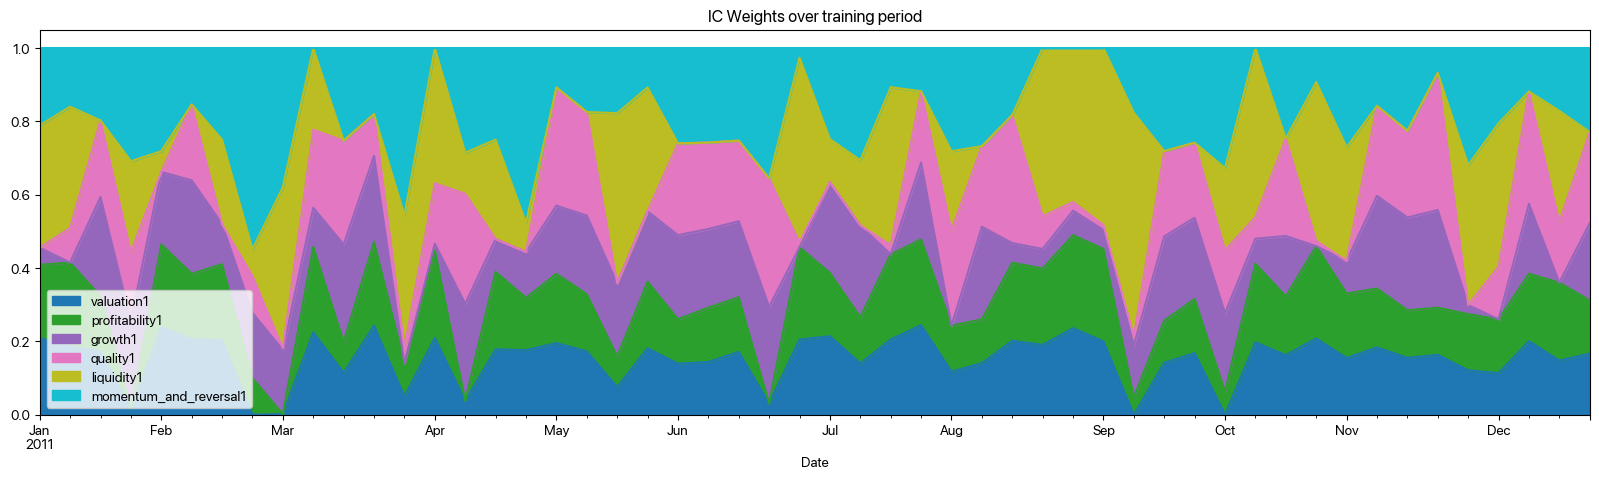

In [117]:
# IC Graph Generation
icwithdate = pd.concat([Date, IC_train.iloc[:, 0:6]], axis=1)
icwithdate.set_index("Date", inplace=True)
icwithdate = icwithdate.sub(icwithdate.min(axis=1), axis=0).div(
    icwithdate.max(axis=1) - icwithdate.min(axis=1), axis=0
)
icwithdate = icwithdate.div(icwithdate.sum(axis=1), axis=0)

icwithdate.plot.area(
    figsize=(20, 5),
    legend=True,
    colormap="tab10",
    title="IC Weights over training period",
)
plt.savefig(dpi=300, fname="icweights.png")


In [118]:
# Model Training
print(IC_train.shape, nextIC_train.shape)
xgbModel.fit(IC_train, nextIC_train)
print(xgbModel.score(IC_train, nextIC_train))


(52, 19) (52, 6)
-0.0008133795101703164


In [119]:
# Model Testing
ic = []
nextic = []
date = []

for i in trange(len(TEST_PERIOD)):
    date.append(TEST_PERIOD[i])
    ic.append(dow30.calcICBulk(TEST_PERIOD[i]) + [dow30.getIndex(TEST_PERIOD[i])])
    if i < len(TEST_PERIOD) - 1:
        nextic.append([dow30.calcIC(factor, TEST_PERIOD[i + 1]) for factor in FACTORS])
    else:
        nextic.append(
            [
                dow30.calcIC(factor, TEST_PERIOD[i] + pd.Timedelta(days=7))
                for factor in FACTORS
            ]
        )

Date = pd.DataFrame(date, columns=["Date"])
IC_test = pd.DataFrame(
    ic,
    columns=[factor + "1" for factor in FACTORS]
    + [factor + "5" for factor in FACTORS]
    + [factor + "10" for factor in FACTORS] + ["Index"],
)
nextIC_test = pd.DataFrame(nextic, columns=FACTORS)

nextIC_test = nextIC_test.fillna(method='ffill')
IC_test = IC_test.fillna(method='ffill')
print(IC_test.shape, nextIC_test.shape)

print(xgbModel.score(IC_test, nextIC_test))
print(xgbModel.predict(IC_test))

100%|██████████| 9/9 [00:01<00:00,  6.31it/s]

(9, 19) (9, 6)
-0.33848761881984474
[[ 0.01809491  0.00577122  0.04694181  0.03890963 -0.01200774  0.1838803 ]
 [ 0.01809491  0.00577122  0.04694181  0.03890963 -0.01200774  0.1838803 ]
 [ 0.01809491  0.00577122  0.04694181  0.03890963 -0.01200774  0.1838803 ]
 [ 0.01809491  0.00577122  0.04694181  0.03890963 -0.01200774  0.1838803 ]
 [ 0.01809491  0.00577122  0.04694181  0.03890963 -0.01200774  0.1838803 ]
 [ 0.01809491  0.00577122  0.04694181  0.03890963 -0.01200774  0.1838803 ]
 [ 0.01809491  0.00577122  0.04694181  0.03890963 -0.01200774  0.1838803 ]
 [ 0.01809491  0.00577122  0.04694181  0.03890963 -0.01200774  0.1838803 ]
 [ 0.01809491  0.00577122  0.04694181  0.03890963 -0.01200774  0.1838803 ]]


In [122]:
from sklearn.model_selection import GridSearchCV

xgbModel_test = MultiOutputRegressor(XGBRegressor())
gridTree = GridSearchCV(
    xgbModel_test,
    param_grid={
        "estimator__n_estimators": [100, 200, 300],
        "estimator__learning_rate": [0.01, 0.02, 0.05],
        "estimator__max_depth": [3, 4, 5, 6],
        "estimator__subsample": [0.2, 0.4, 0.6, 0.8, 1],
        "estimator__colsample_bytree": [0.6, 0.8, 1],
        "estimator__reg_lambda": [0, 10, 20],
        "estimator__gamma": [0, 10, 20],
        "estimator__min_child_weight": [1, 2, 3],
        "estimator__colsample_bylevel": [0.6, 0.8, 1],
        "n_jobs": [-1],
    },
    scoring="r2",
    cv=5,
    n_jobs=-1,
)
gridTree.fit(IC_train, nextIC_train)
print(gridTree.best_params_)
print(gridTree.best_score_)
print(gridTree.best_estimator_)
print(gridTree.score(IC_test, nextIC_test))
optim = gridTree.best_estimator_


{'estimator__colsample_bylevel': 0.6, 'estimator__colsample_bytree': 0.6, 'estimator__gamma': 10, 'estimator__learning_rate': 0.05, 'estimator__max_depth': 3, 'estimator__min_child_weight': 3, 'estimator__n_estimators': 100, 'estimator__reg_lambda': 0, 'estimator__subsample': 0.2, 'n_jobs': -1}
-0.05439165379186224
MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=0.6,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=10,
                                            gpu_id=None, grow_policy=None,
                                            importance_type

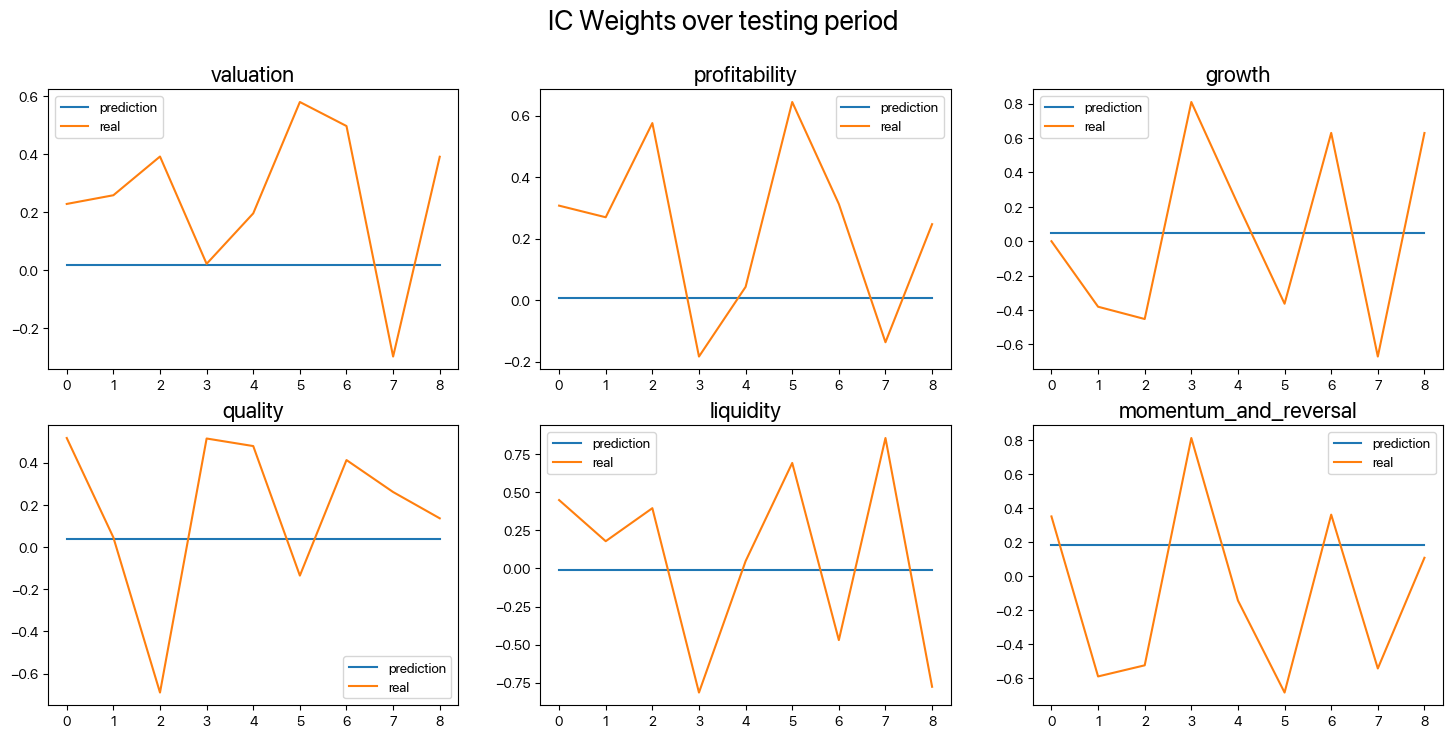

In [121]:
# Graph Plot
plt.figure(figsize=(18, 8))
plt.suptitle("IC Weights over testing period", fontsize=20)
IC_predict = pd.DataFrame(xgbModel.predict(IC_test), columns=FACTORS)
for i in range(len(FACTORS)):
    plt.subplot(2, 3, i + 1)
    plt.title(FACTORS[i], fontsize=16)
    plt.plot(IC_predict.iloc[:, i], label="prediction")
    plt.plot(nextIC_test.iloc[:, i], label="real")
    plt.legend()

plt.savefig(dpi=300, fname = "prediction.png")

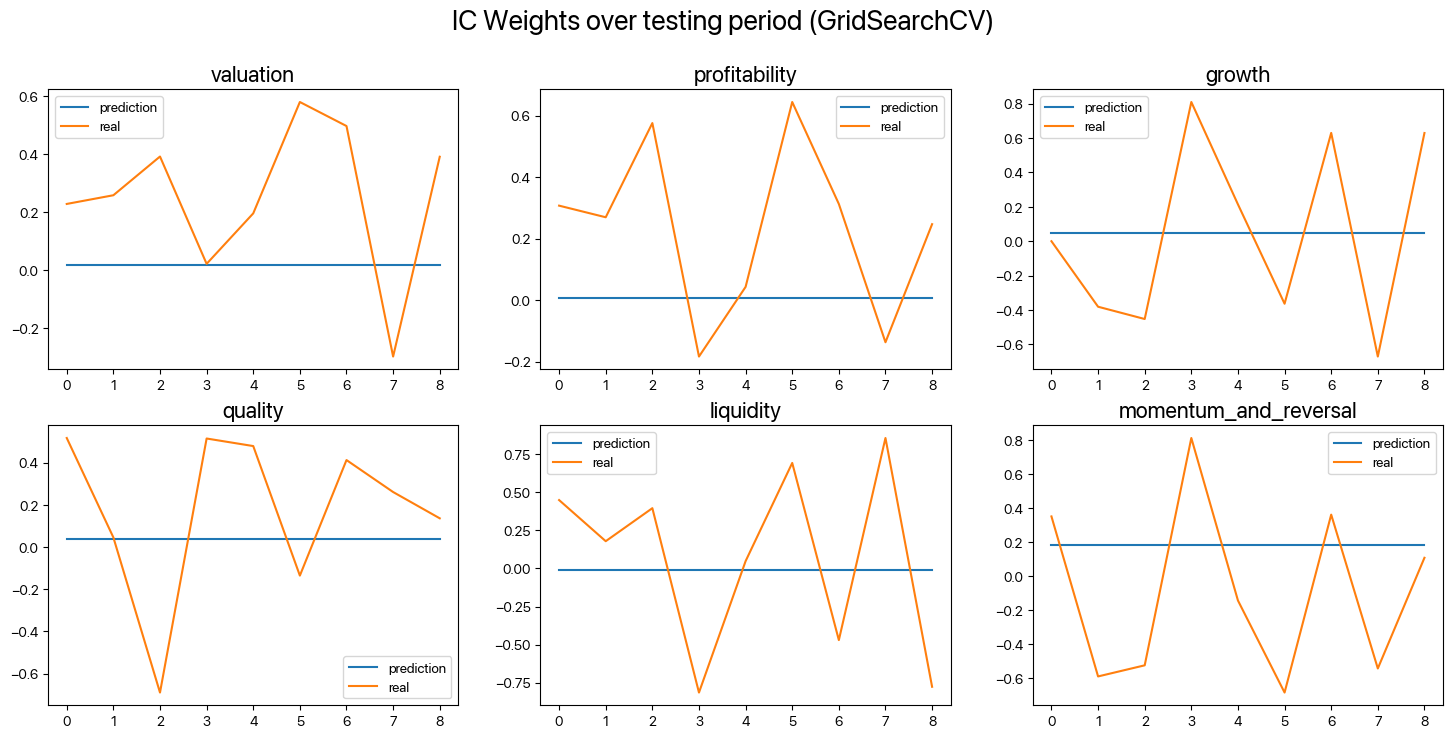

In [ ]:
# Graph Plot
plt.figure(figsize=(18, 8))
plt.suptitle("IC Weights over testing period (GridSearchCV)", fontsize=20)
IC_predict = pd.DataFrame(optim.predict(IC_test), columns=FACTORS)
for i in range(len(FACTORS)):
    plt.subplot(2, 3, i + 1)
    plt.title(FACTORS[i], fontsize=16)
    plt.plot(IC_predict.iloc[:, i], label="prediction")
    plt.plot(nextIC_test.iloc[:, i], label="real")
    plt.legend()

plt.savefig(dpi=300, fname = "prediction.png")